<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a two-photon Calcium Imaging dataset. The demo shows how to construct the `params`, `MotionCorrect` and `cnmf` objects and call the relevant functions. You can also run a large part of the pipeline with a single method (`cnmf.fit_file`). See inside for details.

Dataset couresy of Sue Ann Koay and David Tank (Princeton University)

This demo pertains to two photon data. For a complete analysis pipeline for one photon microendoscopic data see demo_pipeline_cnmfE.ipynb</span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in the companion paper. </span></p>
</html>



In [1]:

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import pylab as pl


Loading BokehJS ...

### Set up logger (optional)
You can log to a file using the filename parameter, or make the output more or less verbose by setting level to `logging.DEBUG`, `logging.INFO`, `logging.WARNING`, or `logging.ERROR`. A filename argument can also be passed to store the log file

In [2]:
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

In [3]:
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [12]:
# fnames = ['Sue_2x_3000_40_-46.tif']  # filename to be processed
# if fnames[0] in ['Sue_2x_3000_40_-46.tif', 'demoMovie.tif']:
#     fnames = [download_demo(fnames[0])]
#rootdir = '/n/home00/juliana.rhee/caiman_data/testdata_jyr'
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522' #'20190505_JC083'
session_dir = os.path.join(rootdir, animalid, session)
fov = 'FOV1_zoom2p0x'
run_label = 'rfs'

In [13]:

data_identifier = '|'.join([animalid, session, fov, run_label])

print("*** Dataset: %s ***" % data_identifier)

*** Dataset: JC084|20190522|FOV1_zoom2p0x|rfs ***


#### Save Caiman output to separate dir

In [14]:
results_dir = os.path.join(session_dir, fov, 'caiman_results', 'retino_run2_rfs')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(results_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs


#### Create output dir for evaluation results

In [35]:
outdir = os.path.join(results_dir, 'motion')
if not os.path.exists(outdir):
    os.makedirs(outdir)

### Setup a cluster
To enable parallel processing a (local) cluster needs to be set up. This is done with a cell below. The variable `backend` determines the type of cluster used. The default value `'local'` uses the multiprocessing package. The `ipyparallel` option is also available. More information on these choices can be found [here](https://github.com/flatironinstitute/CaImAn/blob/master/CLUSTER.md). The resulting variable `dview` expresses the cluster option. If you use `dview=dview` in the downstream analysis then parallel processing will be used. If you use `dview=None` then no parallel processing will be employed.

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
print(n_processes)

#### Load previous MC

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/retino_run2_rfs_mc-rigid.npz
fname
max_shifts
min_mov
border_nan
fname_tot_rig
total_template_rig
templates_rig
shifts_rig
mmap_file
border_to_0


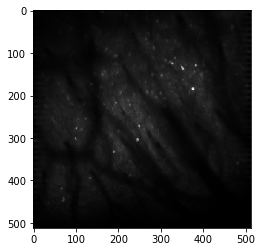

In [21]:
mcresults_path = glob.glob(os.path.join(results_dir, '*_mc-rigid.npz'))[0]
print(mcresults_path)

if mcresults_path is not None:
    mcr = np.load(mcresults_path)
    for k in mcr.keys():
        print(k)
    plt.imshow(mcr['total_template_rig'], cmap = 'gray')

# Load 1 movie and its corresponding correction


In [ ]:
# Load 1 movie and its corresponding correction

orig_fpath = mcr['fname'][12]
mrig_fpath = mcr['fname_tot_rig'][12]

In [46]:
print('orig:', orig_fpath)
print('m_rig:', mrig_fpath)

orig: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/rfs_run1/raw_8a27d9/fov1_rfs_00001.tif
m_rig: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/rfs_run1/raw_8a27d9/fov1_rfs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_2911_.mmap


In [49]:
currfn = os.path.splitext(os.path.split(mrig_fpath)[-1])[0]
data_id = '%s\n%s\n%s' % (data_identifier, orig_fpath, mrig_fpath)


In [29]:
m_orig = cm.load(orig_fpath)
m_orig.shape

(2911, 512, 512)

In [30]:
m_rig = cm.load(mrig_fpath) #cm.load(mc.mmap_file)
m_rig.shape

(2911, 512, 512)

### Play the movie (optional)
Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [34]:
ds_ratio = 0.1
cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mcr['min_mov'],
                m_rig.resize(1, 1, ds_ratio)], axis=2).play(fr=60, q_max=100, 
                                                            magnification=1, bord_px=mcr['border_to_0'])

In [51]:
print(outdir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/motion


# Plot rigid shifts

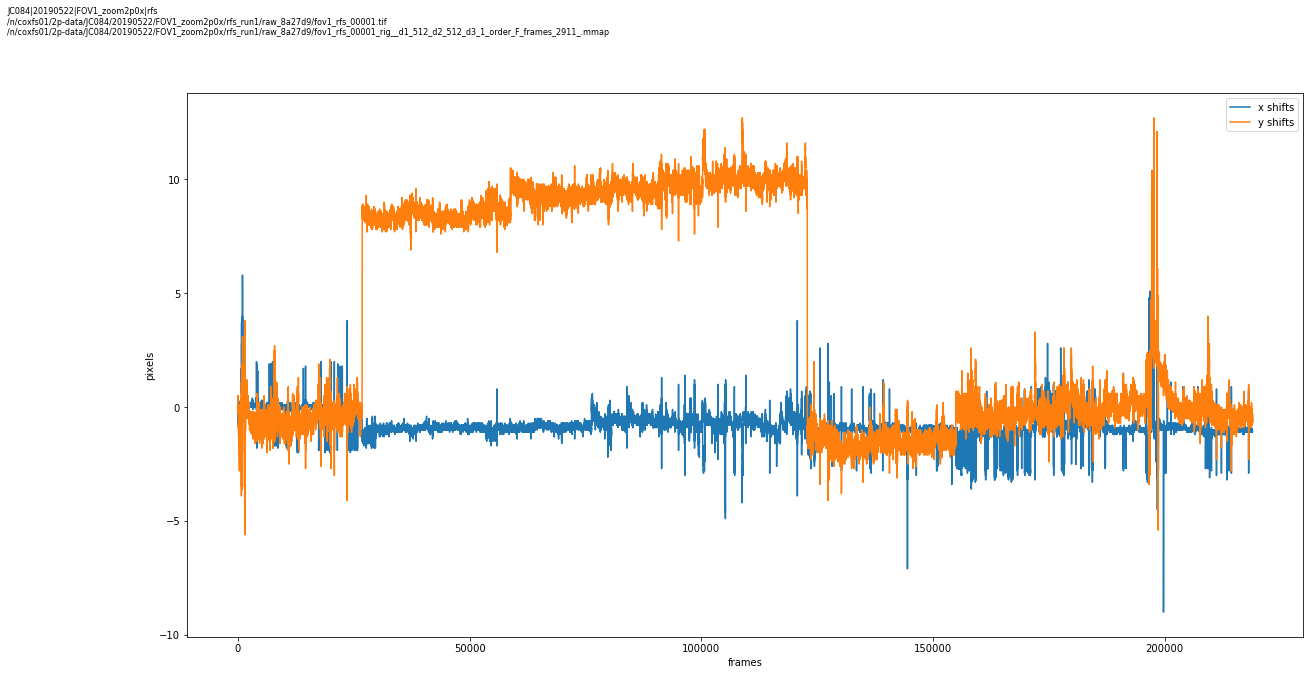

In [50]:
#%% plot rigid shifts
fig = plt.figure(figsize = (20,10))
plt.plot(mcr['shifts_rig'])
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

label_figure(fig, data_id)
plt.savefig(os.path.join(outdir, 'rigid-shifts_%s.png' % currfn))


# Plot correlation images

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)



In [38]:
Cn_orig = m_orig.local_correlations(eight_neighbours=True, swap_dim=False)
Cn_rig = m_rig.local_correlations(eight_neighbours=True, swap_dim=False)

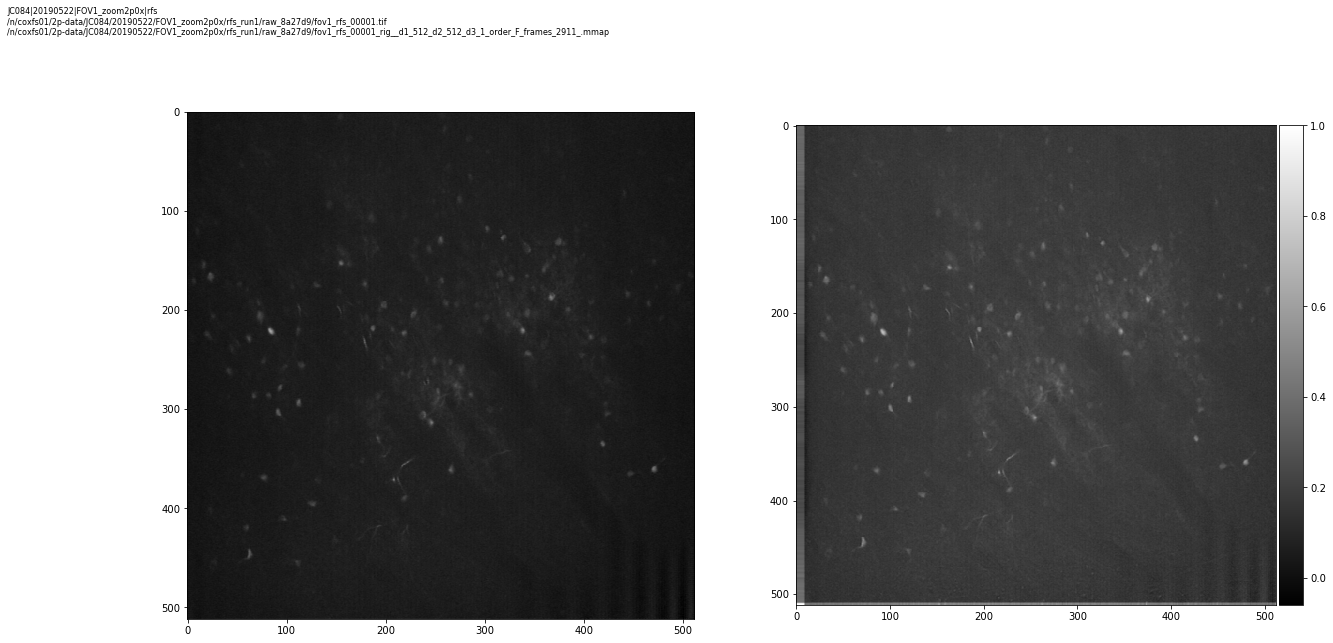

In [52]:
vmin = min([0, Cn_rig.min(), Cn_orig.min()])
vmax = max([Cn_rig.max(), Cn_orig.max()])
cmap = 'gray'

fig, axes = pl.subplots(1, 2, figsize = (20,10))
im1 = axes[0].imshow(Cn_orig, vmin=vmin, vmax=vmax, cmap=cmap)


im2 = axes[1].imshow(Cn_rig, vmin=vmin, vmax=vmax, cmap=cmap)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

label_figure(fig, data_id)

plt.savefig(os.path.join(outdir, 'local-correlations_orig-v-mrig_%s.png' % (currfn)))

# Compute metrics

In [53]:
#% compute metrics for the results (TAKES TIME!!)
bord_px_rig = mcr['border_to_0']
final_size = np.subtract(mcr['total_template_rig'].shape, 2 * bord_px_rig) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF
print(final_size)

[486 486]


In [55]:
movix = 12
tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    mcr['fname'][movix], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mcr['fname_tot_rig'][movix], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


In [69]:
def move_metric_results(fname):
    oldname = fname[:-4] + '_metrics.npz'
    newname = os.path.join(outdir, os.path.split(oldname)[-1])
    os.rename(oldname, newname)
    return newname

In [72]:
# move metric results to motion dir

raw_metrics_path = move_metric_results( mcr['fname'][movix] )
rig_metrics_path = move_metric_results( mcr['fname_tot_rig'][movix] )


# raw_metrics_path = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/motion/fov1_rfs_00001_metrics.npz'
# rig_metrics_path = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/motion/fov1_rfs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_2911_._metrics.npz'

#### Plot correlation with mean frame for current dataset

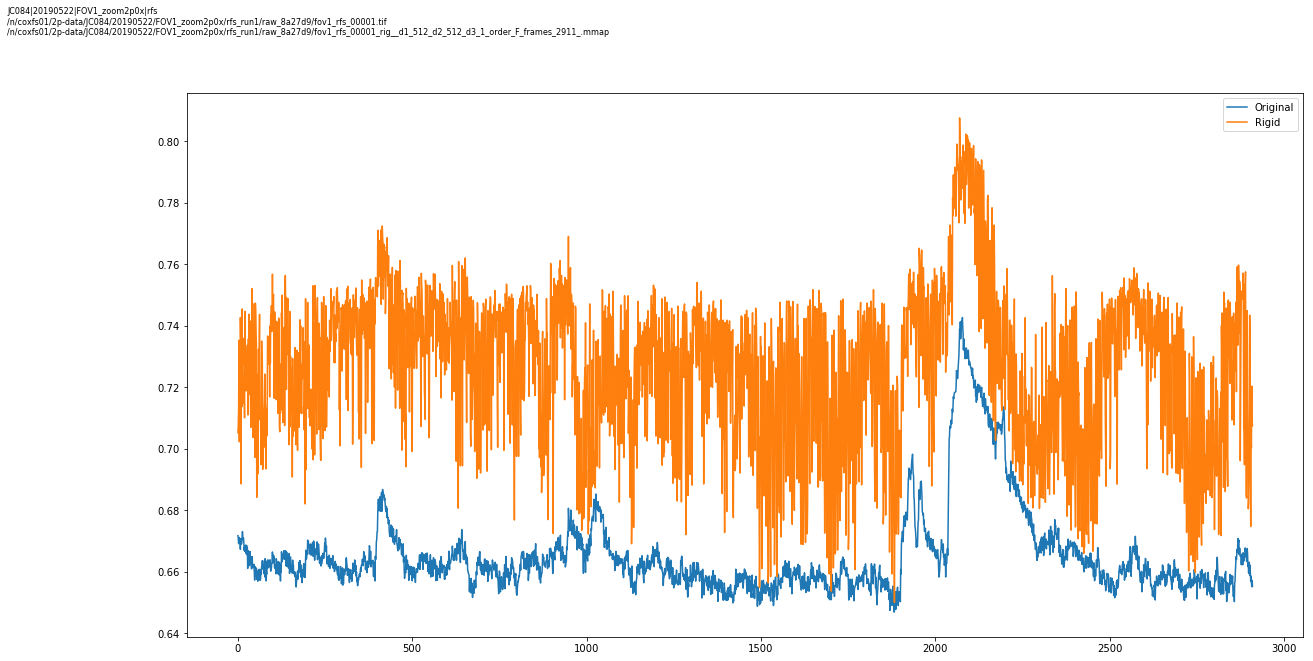

In [96]:
fig = pl.figure(figsize = (20,10))

plt.subplot(111); 
plt.plot(correlations_orig); plt.plot(correlations_rig); #plt.plot(correlations_els)
plt.legend(['Original','Rigid'])

label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'correlation-with-mean_%s.png' % currfn))


#### Plot as scatter

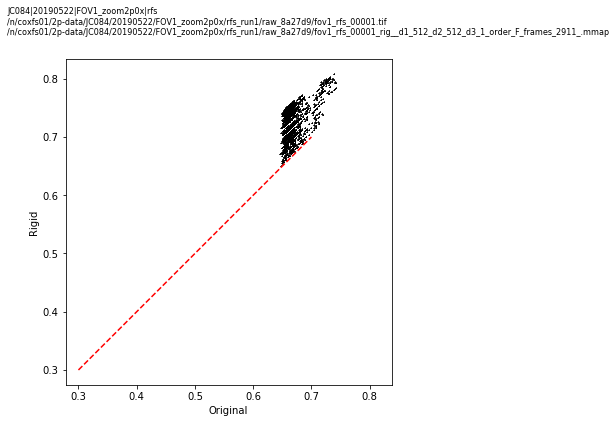

In [95]:
fig = pl.figure(figsize = (6,6))

plt.subplot(111); 
plt.scatter(correlations_orig, correlations_rig, s=1, marker='+', c='k'); 
plt.xlabel('Original'); 
plt.ylabel('Rigid'); 
plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
#plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'correlation-with-mean-scatter_%s.png' % currfn))


In [78]:

# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))


Crispness original: 27316
Crispness rigid: 27546


#### Plot optic flow results

In [88]:
orig_file[:-4]

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/rfs_run1/raw_8a27d9/fov1_rfs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_2911_.'

KeysView(<numpy.lib.npyio.NpzFile object at 0x2b90d5907c50>)
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/motion/fov1_rfs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_2911_._metrics.npz
64.97098+/-25.412275 ; 27546.965 ; 6.264369588996839


     4386705 [movies.py:                load():1394] [154564] File request:[/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/rfs_run1/raw_8a27d9/fov1_rfs_00001mmap] not found!


KeysView(<numpy.lib.npyio.NpzFile object at 0x2b90d5907240>)
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/motion/fov1_rfs_00001_metrics.npz
106.416214+/-42.88138 ; 27316.04 ; 5.339576153018815


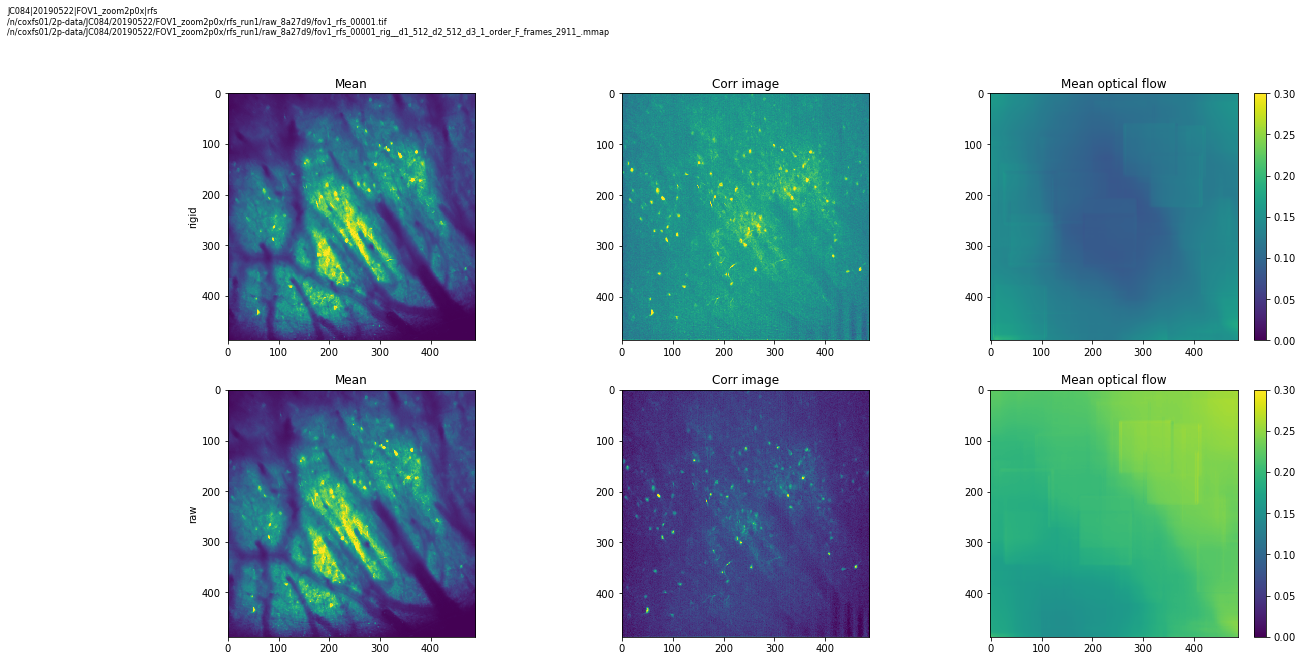

In [90]:

#%% plot the results of Residual Optical Flow
#fls = [mcr['fname_tot_rig'][movix][:-4] + '_metrics.npz', mcr['fname'][movix][:-4] + '_metrics.npz']
fls = [rig_metrics_path, raw_metrics_path]
orig_fls = [mcr['fname_tot_rig'][movix], mcr['fname'][movix]]

fig = plt.figure(figsize = (20,10))
for cnt, fl, metr, orig_file in zip(range(len(fls)), fls, ['rigid','raw'], orig_fls):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(orig_file[:-4] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(orig_file[:-4] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(orig_file[:-4] + '.hdf5'), 0)[12:-12, 12:-12]
                
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')
        
        
label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'optic-flow_orig-vs-mrig_%s.png' % currfn))

In [ ]:
#%% compare with original movie
display_movie = False
save_movie = False

ds_ratio = 0.05
m_orig = cm.load_movie_chain(fnames)

if display_movie:
    cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mc.min_mov*mc.nonneg_movie,
                    m_rig.resize(1, 1, ds_ratio)], 
                   axis=2).play(fr=60, gain=15, magnification=2, offset=0)  # press q to exit
elif save_movie:
    # save movie
    mcmovie = cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mc.min_mov*mc.nonneg_movie,
                    m_rig.resize(1, 1, ds_ratio)], 
                   axis=2)#.play(fr=60, gain=15, magnification=2, offset=0)
    mcmovie.save(os.path.join(results_dir, 'mc_rigid_mov.tif'))
    

## Closing, saving, and creating denoised version
### You can save an hdf5 file with all the fields of the cnmf object

In [41]:
save_results = True
if save_results:
    cnm2.save(os.path.join(results_dir, 'cnm2_analysis_results.hdf5'))


### Stop cluster and clean up LOG files

In [21]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

### View movie with the results
We can inspect the denoised results by reconstructing the movie and playing alongside the original data and the resulting (amplified) residual movie

In [ ]:
cnm2.estimates.play_movie(images, q_max=99.9, gain_res=2,
                                  magnification=2,
                                  bpx=border_to_0,
                                  include_bck=False)

The denoised movie can also be explicitly constructed using:

In [ ]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
                    cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

# Look at saved results

In [8]:
from caiman.source_extraction.cnmf.cnmf import load_CNMF


In [9]:
results_fpath = os.path.join(results_dir, 'analysis_results.hdf5')
print(results_fpath)
cnm = load_CNMF(results_fpath, n_processes=8)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/analysis_results.hdf5


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [10]:
cnm.estimates.A.shape

(262144, 839)

In [11]:
cnm.params.quality

{'SNR_lowest': 0.5,
 'cnn_lowest': 0.1,
 'gSig_range': None,
 'min_SNR': 2.0,
 'min_cnn_thr': 0.99,
 'rval_lowest': -1,
 'rval_thr': 0.85,
 'use_cnn': True}

In [12]:
# Re-evaluate components:

cnm.params.quality['SNR_lowest'] = 1.
# cnm.params.quality['cnn_lowest'] = 0.2
# {'SNR_lowest': 0.5,
#  'cnn_lowest': 0.1,
#  'gSig_range': None,
#  'min_SNR': 2.0,
#  'min_cnn_thr': 0.99,
#  'rval_lowest': -1,
#  'rval_thr': 0.85,
#  'use_cnn': True}

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)
print(cnm.estimates.A.shape)

Using TensorFlow backend.
      218944 [deprecation.py:            new_func():323] [11945] From /n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
      218996 [deprecation.py:            new_func():506] [11945] From /n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


USING MODEL:/n/home00/juliana.rhee/caiman_data/model/cnn_model.json
839/839 [==============================] - 2s 3ms/step
(262144, 839)


In [13]:
#%% Extract DF/F values
cnm.estimates.detrend_df_f(quantileMin=8, frames_window=250)

#%% Select only high quality components
cnm.estimates.select_components(use_object=True)

In [14]:
print(cnm.estimates.A.shape)

(262144, 300)


In [15]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.Cn = Cn
cnm.estimates.plot_contours_nb(img=Cn)

pl.savefig(os.path.join(results_dir, 'final_components_eval3.png'))

NameError: name 'pl' is not defined

In [103]:
cnm.save(os.path.join(results_dir, 'analysis_results.hdf5'))


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [17]:
print("A:", cnm.estimates.A.shape)
print("C:", cnm.estimates.C.shape)

A: (262144, 300)
C: (300, 26796)


In [18]:
Av = images.mean(axis=0)
cnm.estimates.plot_contours_nb(img=Av)

pl.savefig(os.path.join(results_dir, 'final_components_Av_eval3.png'))

<Figure size 432x288 with 0 Axes>

In [20]:
save_movie = False
frame_range = np.arange(0, 2233)

if save_movie:
    # Make save movie:

    # denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
    #                     cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised = cm.movie(cnm.estimates.A.dot(cnm.estimates.C[:, frame_range])).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised.save(os.path.join(results_dir, 'denoised_mov.tif'))
